In [1]:
#| hidden: true
#| echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# some personal style settings to make the plots look nice
# and save some space in the notebook
plt.style.use("../style.mplstyle")

## Course Goals 

Our basic goals for the course are:

1) to build a strong intuition about data, where it comes from, and what questions it can answer. 

2) to learn the basic computational skills needed to manipulate and analyze data. Working with data also helps with (1)!

## Why statistics? 
Statistics is, essentially, the study of data and how to use it. People argue about the purpose of statistics, but basically you can do 3 things with data: 

1. description 
2. inference
3. prediction 

## Description {style="font-size:20px;"}
::: {.notes}
Descriptive statistics is the process of summarizing data. This can be done with numbers (e.g., mean, median, standard deviation) or with visualizations (e.g., histograms, boxplots). Descriptive statistics, importantly, are completely limited to the sample of data at hand. 
:::
Let's load in some data and take a look at it.

The [dataset](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata) contains Airbnb listings in New York City, including prices, locations, and other features. 

## Description
<!-- ^[from https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata] -->

In [2]:
# import the data on Airbnb listings in the New York City
airbnb = pd.read_csv("../data/airbnb.csv")
# data cleaning
airbnb = airbnb.rename(columns={"neighbourhood_group": "borough"})
airbnb = airbnb.dropna(subset=["borough", "price", "long", "lat"])
airbnb["borough"] = airbnb["borough"].str.lower()
airbnb["borough"] = airbnb["borough"].str.replace("manhatan", "manhattan")
airbnb["borough"] = airbnb["borough"].str.replace("brookln", "brooklyn")
# format the price column
airbnb['price'] = airbnb['price'].replace({'\\$': '', ',': ''}, regex=True).astype(float)
# print the first 5 rows
airbnb[:3].head()


/var/folders/7h/662tdm8d6sn0krrht717wzmm0000gq/T/ipykernel_73130/190850660.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb = pd.read_csv("../data/airbnb.csv")


,id,name,host_id,host_identity_verified,host_name,borough,neighbourhood,lat,long,country,...,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN



---

Now there's a lot you can do, but let's start by visualizing the prices of listings.


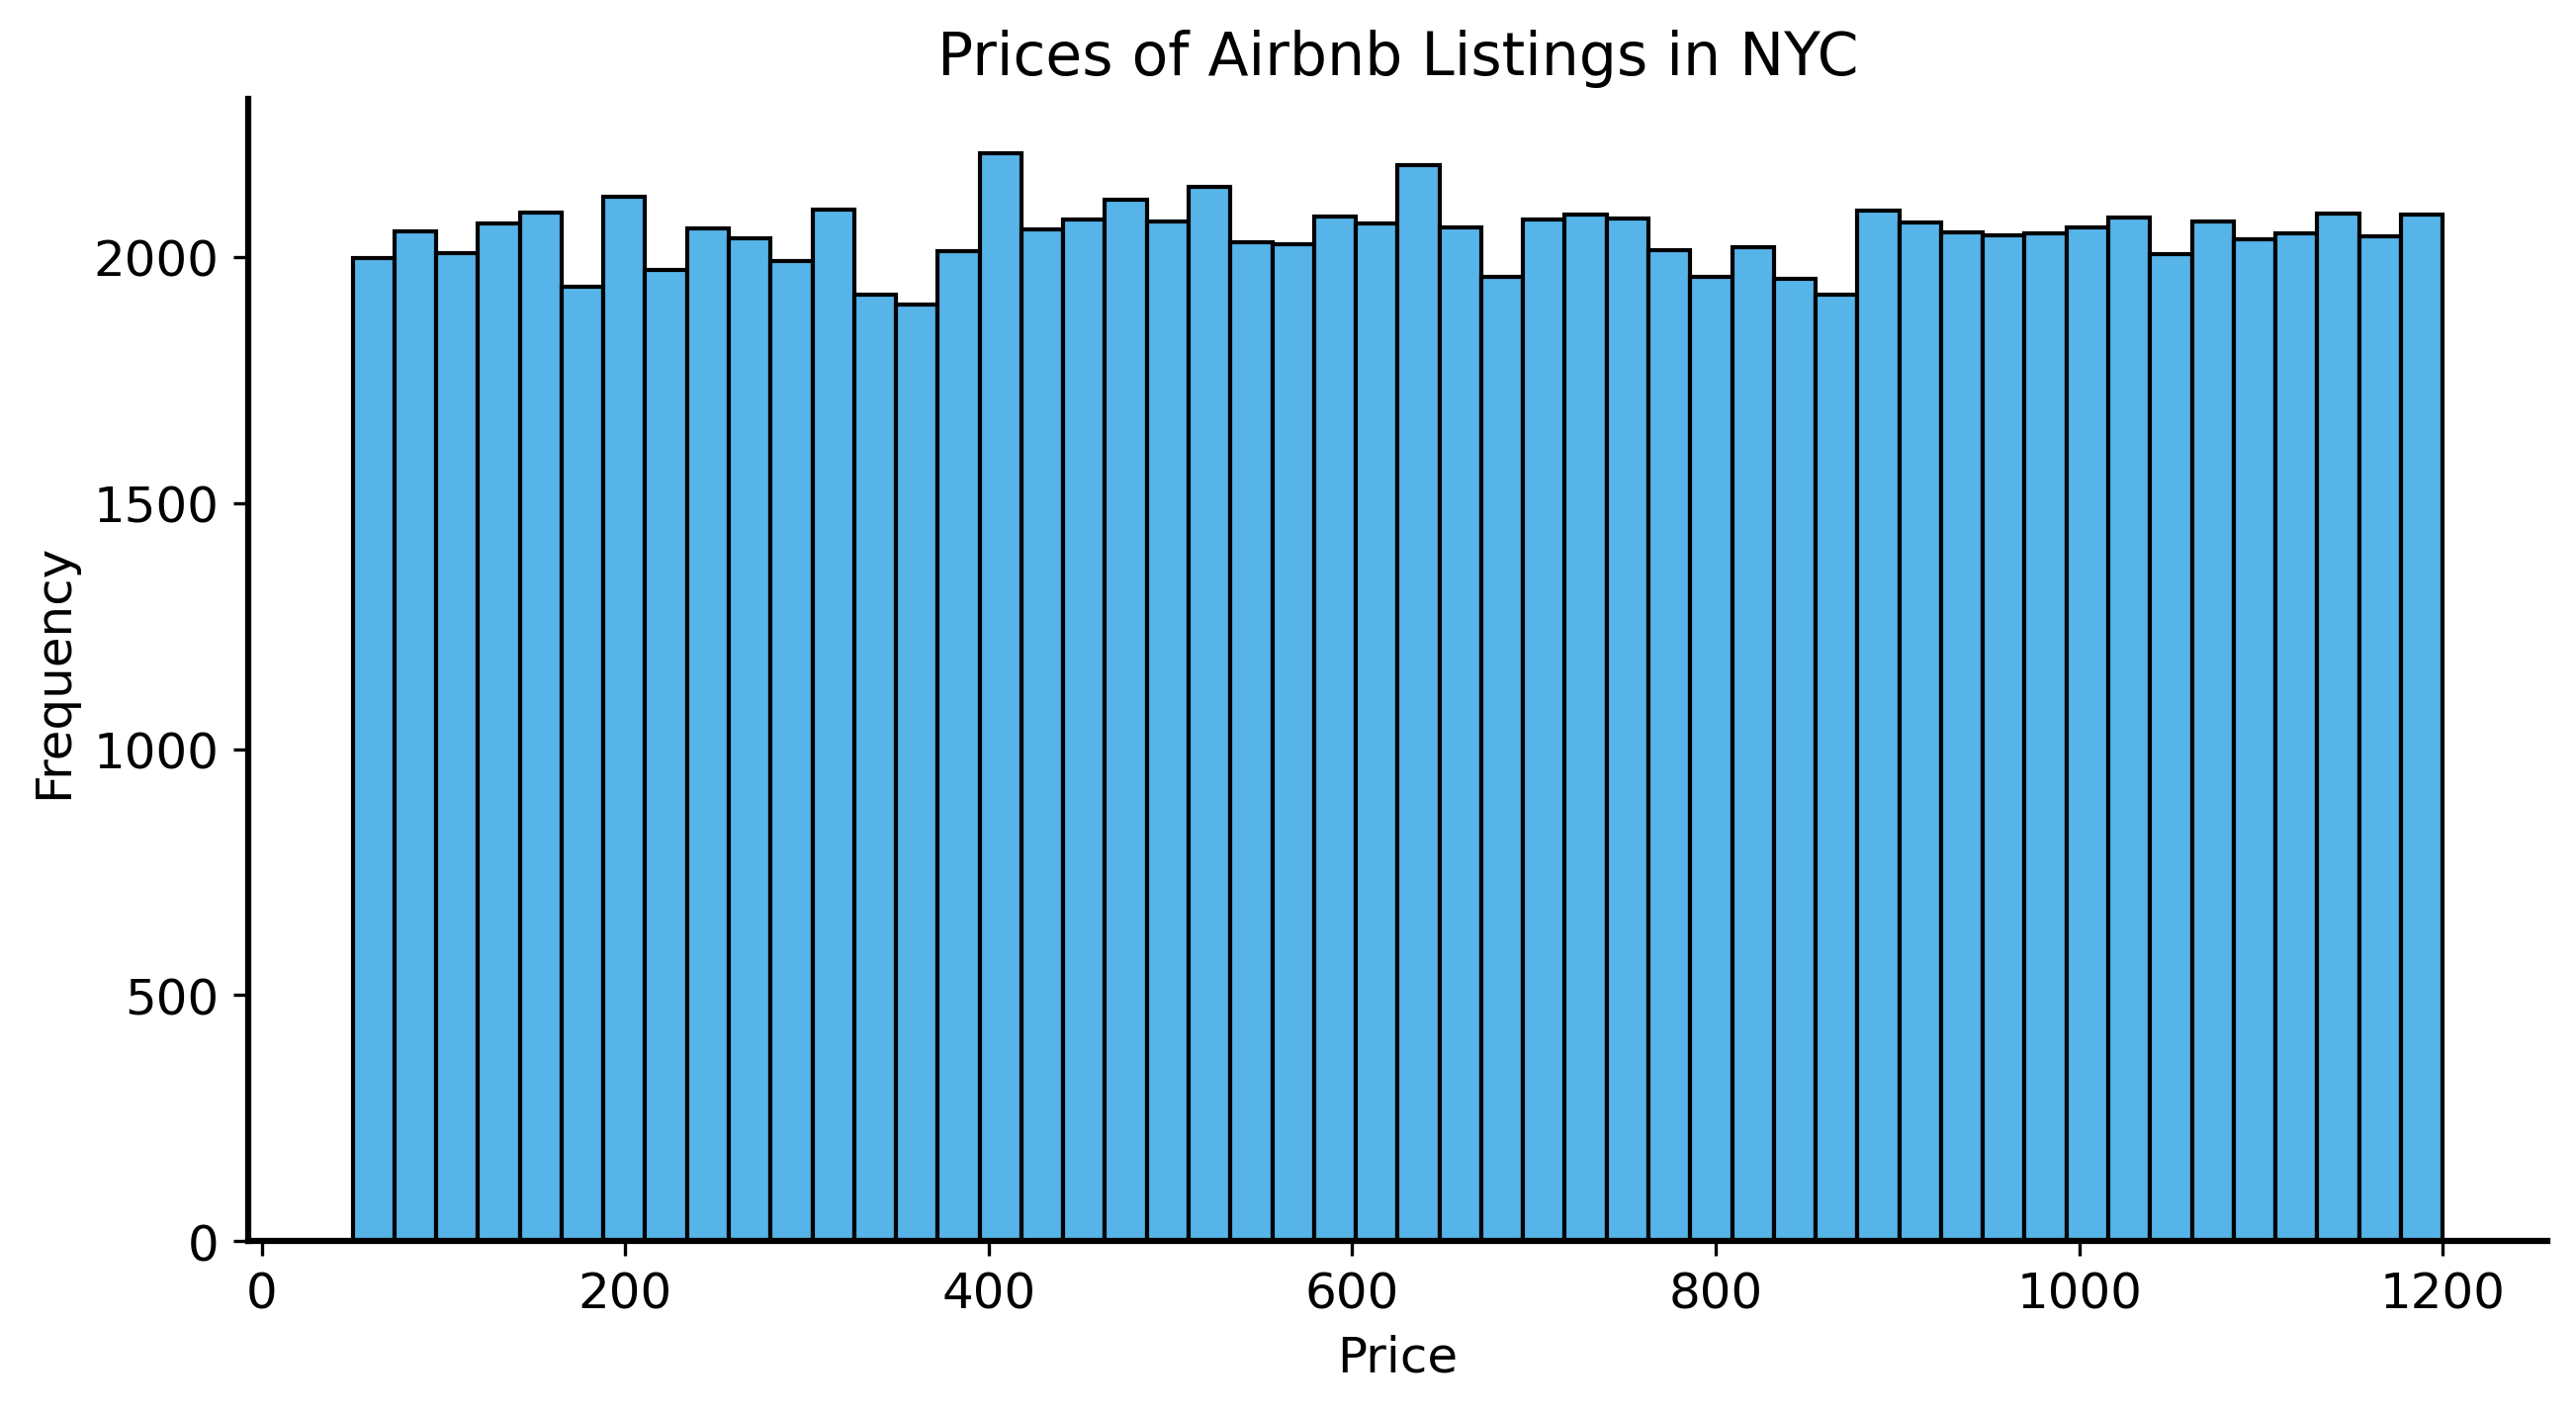

In [3]:
# plot a histogram of the price column
plt.figure(figsize=(10, 5))
plt.hist(airbnb['price'], bins=50)
plt.title('Prices of Airbnb Listings in NYC')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

---

Computing statistics like the mean (average), standard deviation (average distance from the mean), and quartiles (top 25% and bottom 25%) is easy.

In [4]:
airbnb["price"].describe()

count    102316.000000
mean        625.291665
std         331.677344
min          50.000000
25%         340.000000
50%         624.000000
75%         913.000000
max        1200.000000
Name: price, dtype: float64


---

We can even use specialized libraries to make use of the geographic information in the data. For example, we can use the `geopandas` library to plot the locations of listings on a map of New York City. 


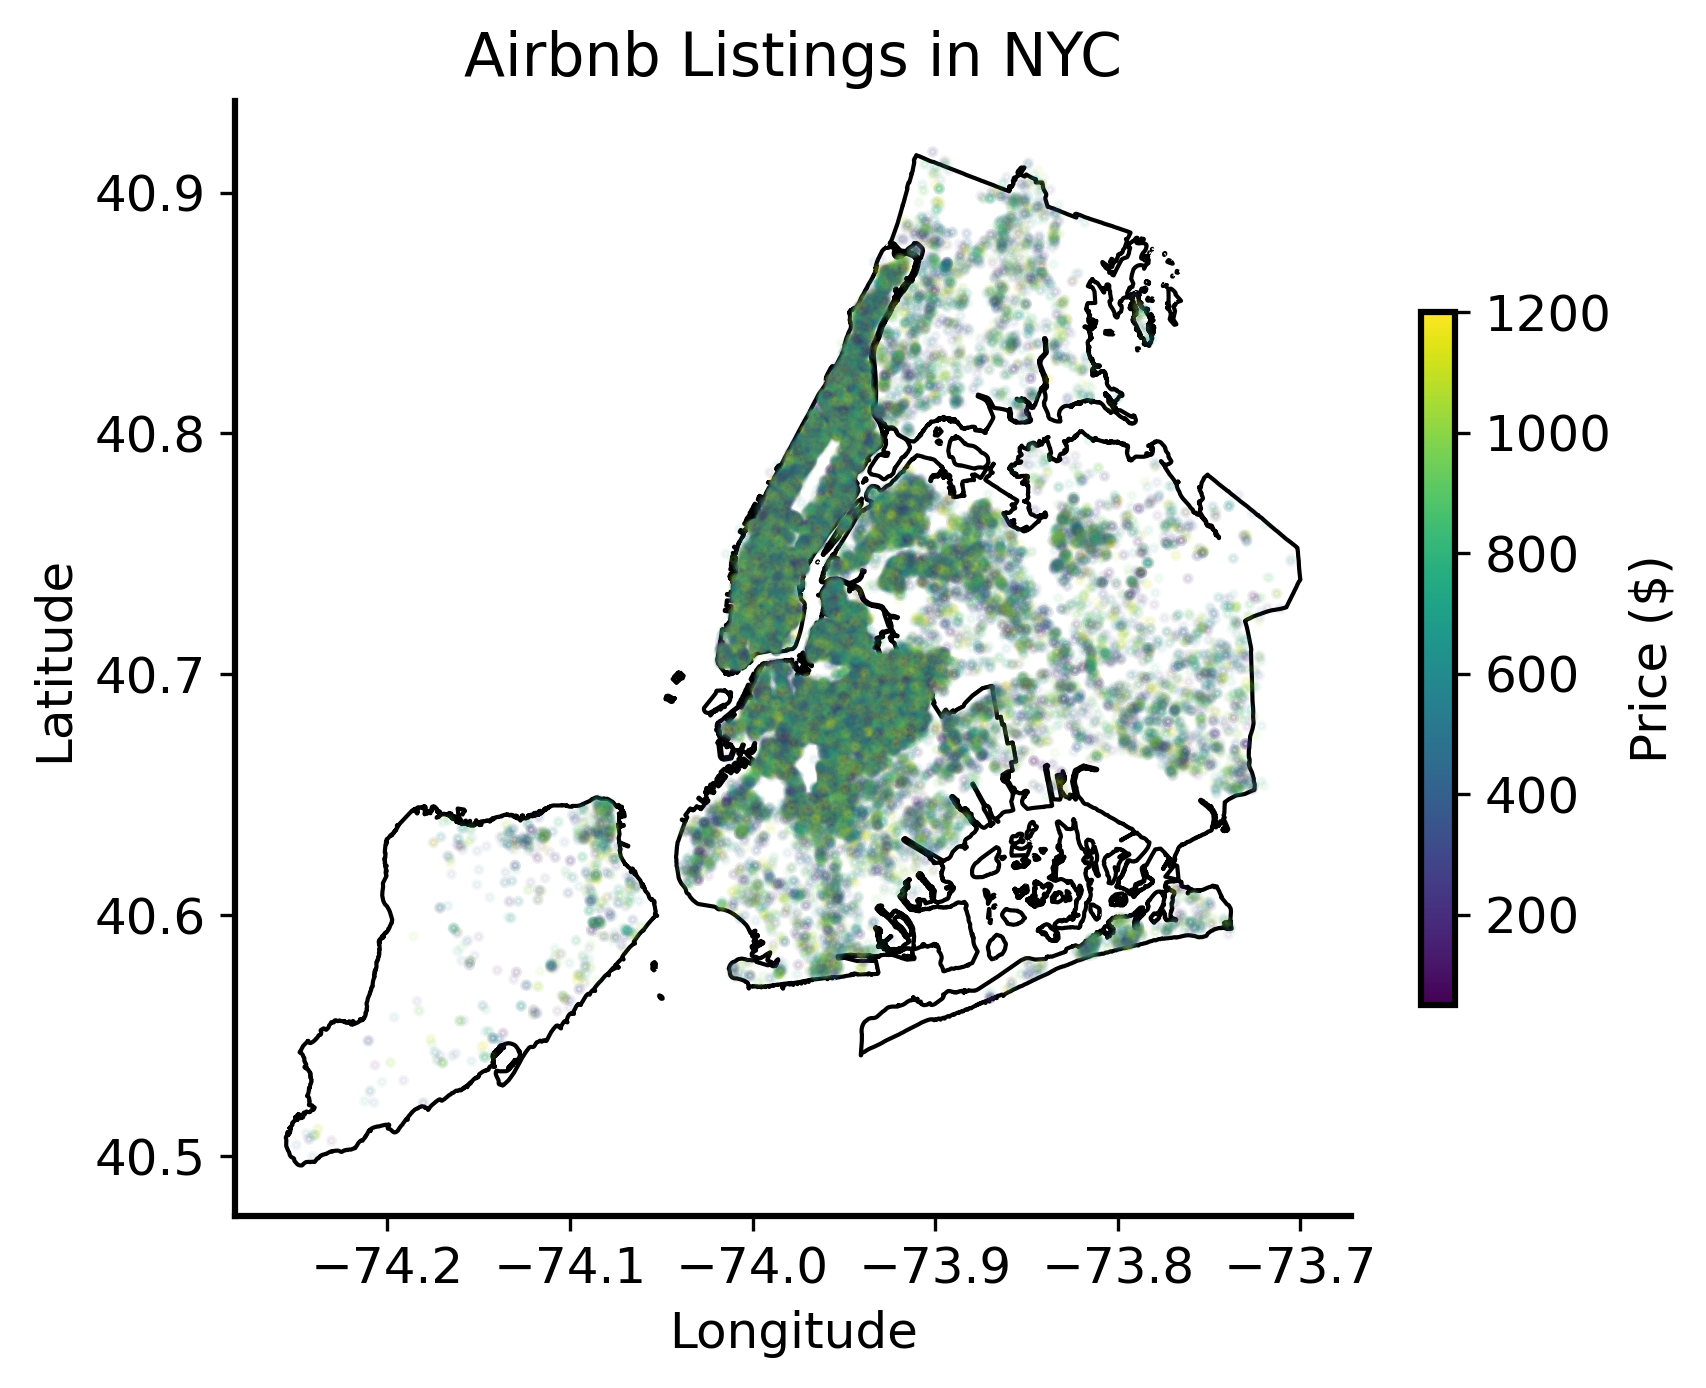

In [5]:
# | fig-align: center
import geopandas as gpd
from geodatasets import get_path

fig, ax = plt.subplots(figsize=(6, 6))
# load the shapefile of NYC neighborhoods
nyc_neighborhoods = gpd.read_file(get_path("nybb"))
nyc_neighborhoods = nyc_neighborhoods.to_crs(epsg=4326)  # convert to WGS84
# plot the neighborhoods with airbnb listings
nyc_neighborhoods.plot(ax=ax, color="white", edgecolor="black")
# plot the airbnb listings on top of the neighborhoods
# use the 'long' and 'lat' columns to create a GeoDataFrame
airbnb_gdf = gpd.GeoDataFrame(
    airbnb, geometry=gpd.points_from_xy(airbnb["long"], airbnb["lat"]), crs="EPSG:4326"
)
# set the coordinate reference system to WGS84
airbnb_gdf.plot(
    ax=ax,
    column="price",
    markersize=3,
    alpha=0.05,
    legend=True,
    cmap="viridis",
    legend_kwds={"shrink": 0.5, "label": "Price ($)"},
)
plt.title("Airbnb Listings in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


---
::: {.notes}
There is a lot of information in the data, and we can summarize it in many different ways. But descriptive statistics **only describe the data**. 

Why is this limiting? After all, we like data -- it tells us things about the world and it's objective and quantifiable. 

The problem is that data is not always complete. In fact, it almost never is. And incomplete data can lead to misleading conclusions.
:::

Let's look at our Airbnb data again. What if instead of looking at the entire dataset, we only looked at a small "sample" or subset of the data?

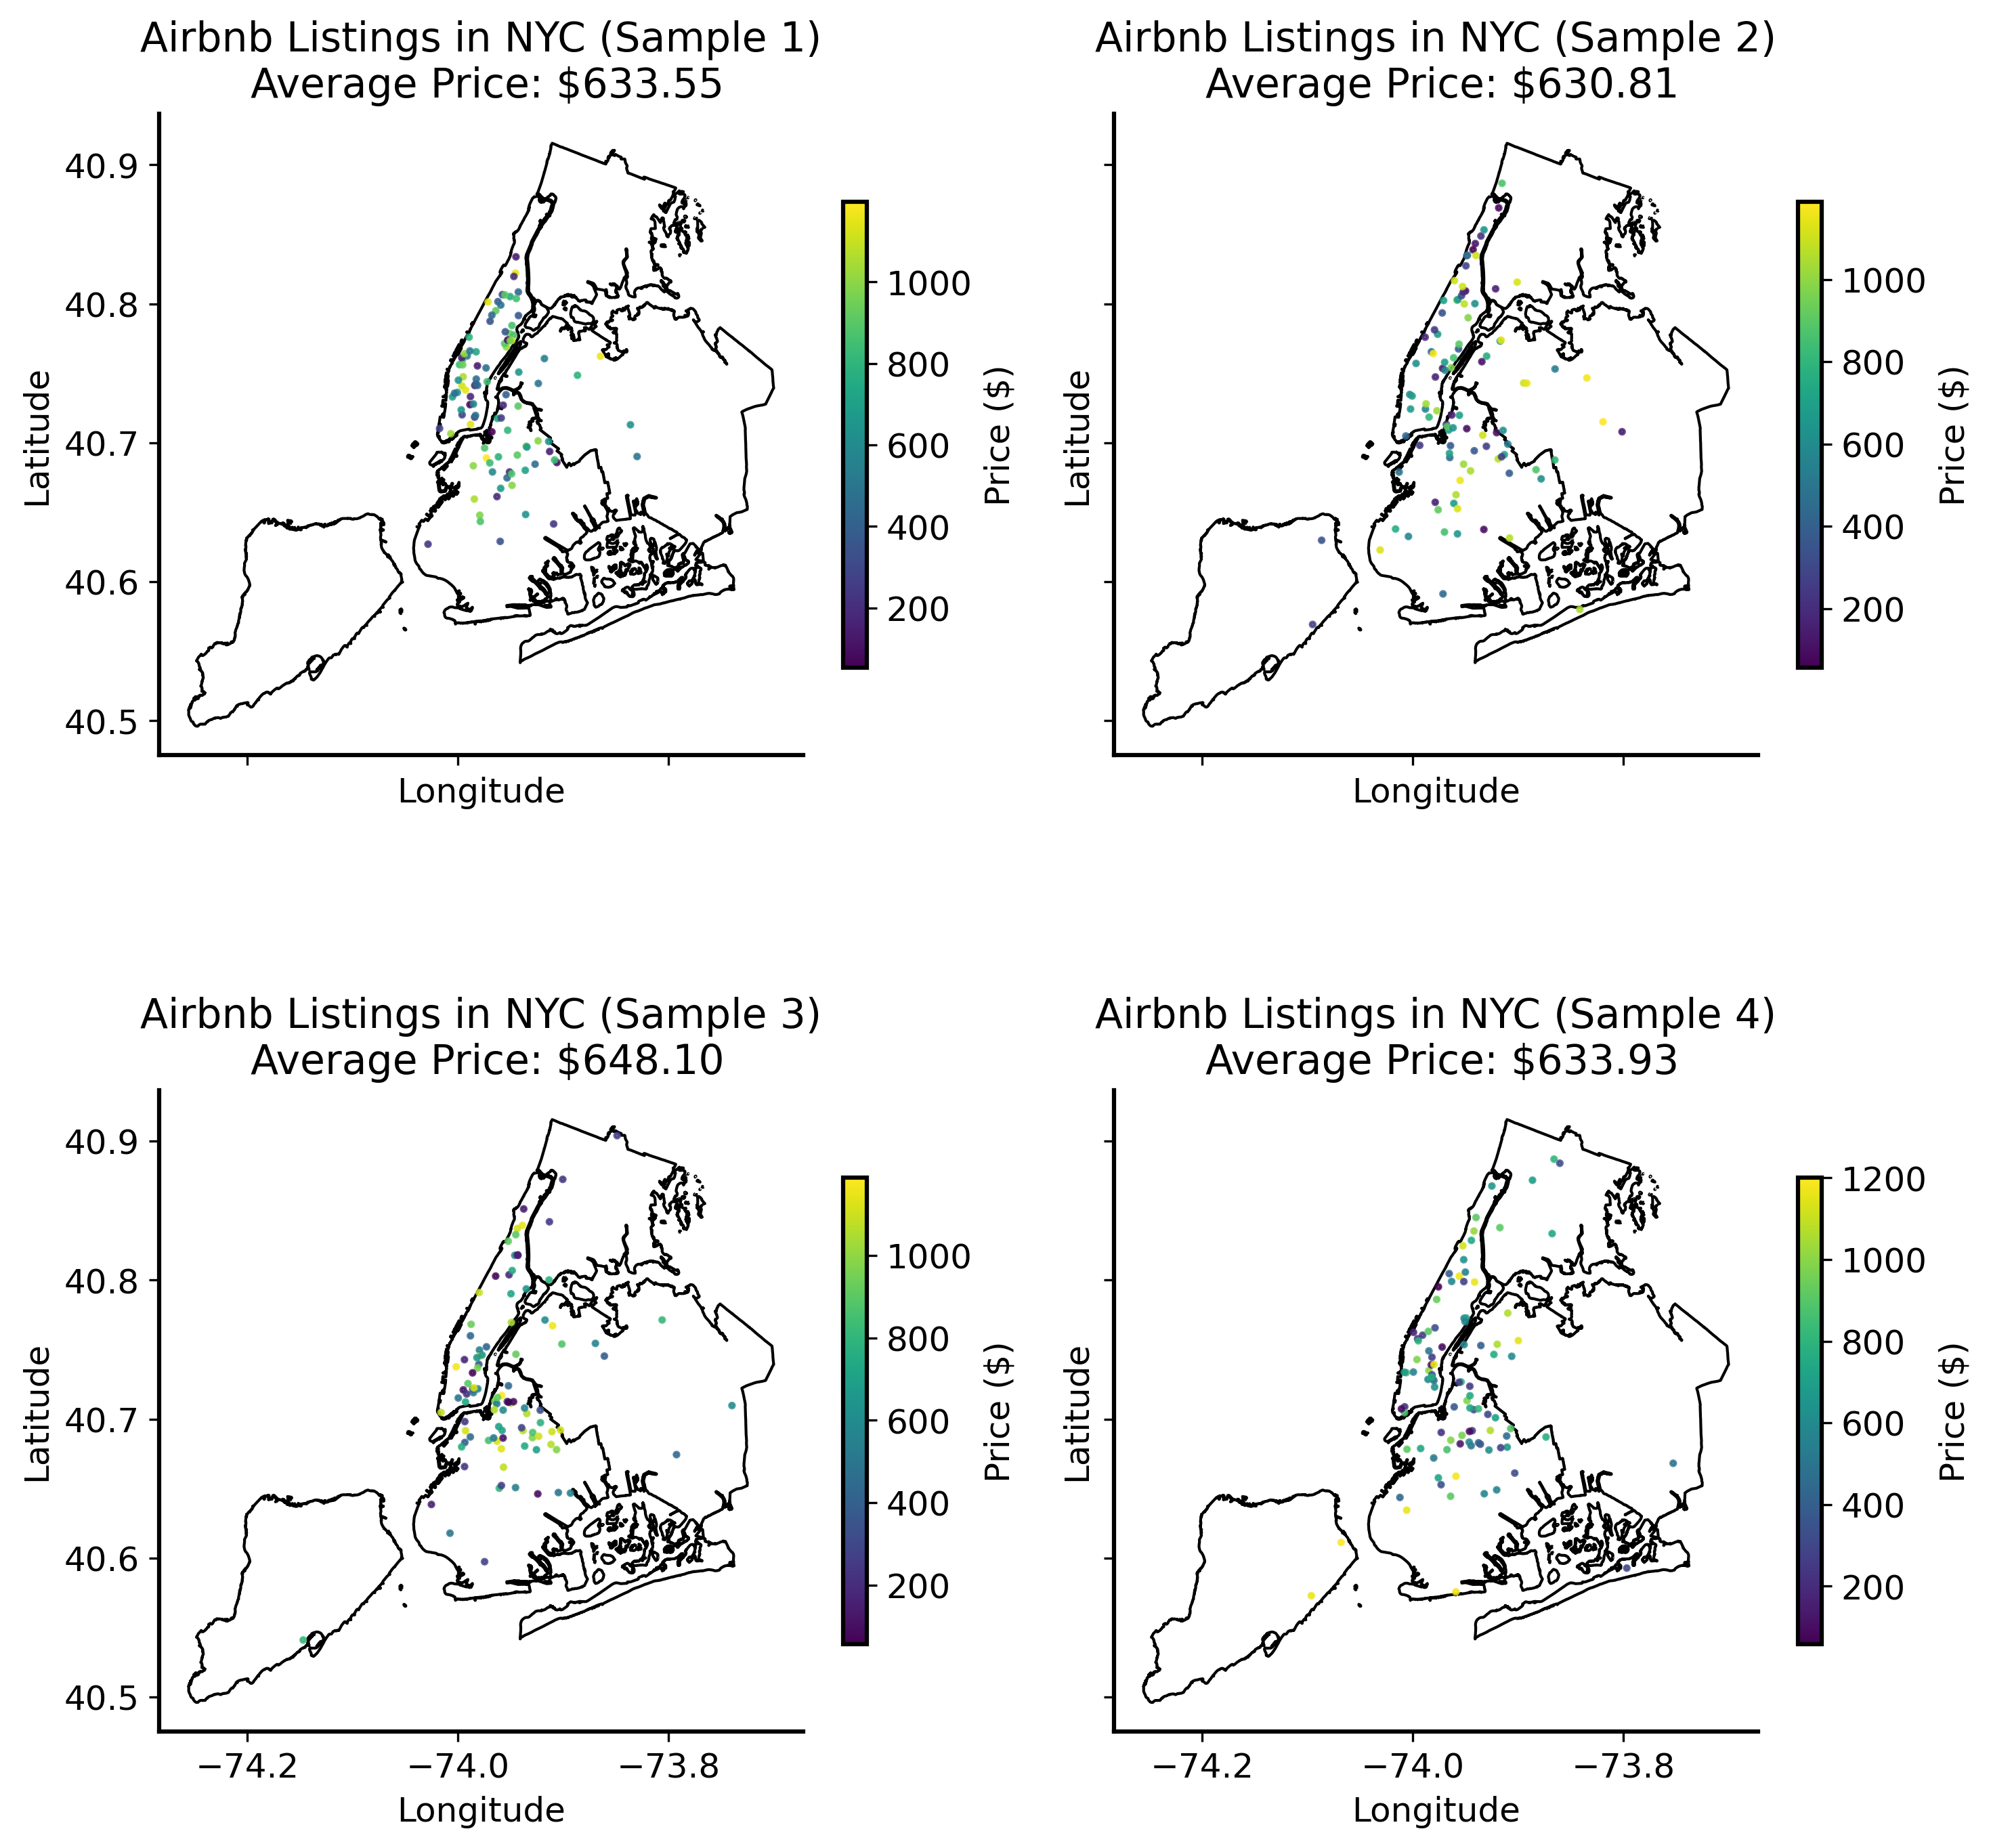

In [6]:
#| fig-align: center
#| label: fig:airbnb-samples
# separately plot 3 samples of airbnb listings
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(4):
    # sample 1000 listings
    sample = airbnb.sample(100, random_state=i)
    # plot the neighborhoods with airbnb listings
    nyc_neighborhoods.plot(ax=ax[i], color="white", edgecolor="black")
    # plot the airbnb listings on top of the neighborhoods
    # use the 'long' and 'lat' columns to create a GeoDataFrame
    airbnb_gdf_sample = gpd.GeoDataFrame(sample, geometry=gpd.points_from_xy(sample['long'], sample['lat']), crs='EPSG:4326')
    # set the coordinate reference system to WGS84
    airbnb_gdf_sample.plot(ax=ax[i], column="price", markersize=3, alpha=0.8, legend=True, cmap='viridis', legend_kwds={'shrink': 0.5, 'label': 'Price ($)'})
    ax[i].set_title(f'Airbnb Listings in NYC (Sample {i+1})\n Average Price: ${sample["price"].mean():.2f}')
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Latitude')
plt.tight_layout()
plt.show()

## Sample $\neq$ Population
:::: {.notes}
Notice how the samples differ from one another. They have different geography and different prices. This means you can't just look at the descriptive statistics of a single sample and draw conclusions about the entire population.
:::

**Population**

the entire set of data that you are interested in. 

**Sample**

a subset of a population. 

A *random sample* is a sample that is selected randomly from the population. 

. . .

:::{.callout-tip title="Example: Airbnb listings in New York City"} 
We want to know the average price of Airbnb listings in New York City.

- *population*: all Airbnb listings in New York City
- *sample*: a smaller subset of those listings, which may or may not be representative of the entire population.

:::

## What is the population?

Flexible definition:

- Average price of all short-term rentals in New York City? Population: all rentals (not just Airbnb listings) in New York City.

. . .

Often, the population is actually more abstract or theoretical
 
- Average price of all possible Airbnb listings in New York City? Population: all potential listings, not just the ones that currently exist.

. . .

Descriptive statistics are useful for understanding the data at hand, but they don't necessarily tell us much about the world outside of the data. For that, we need to do something more. 

## Quiz: restaurant survey

In [7]:
#| echo: false
from jupyterquiz import display_quiz

example = [{"question": "You are interested in finding the best restaurant in Philadelphia, so you survey 1000 people and ask them to rank their top 10 favorite restaurants in the city. What is the population corresponding to this sample?",
          "type": "many_choice",
          "answers":[
            {"answer": "All restaurants in Philadelphia", "correct":False},
            {"answer": "The 1000 people surveyed", "correct":False},
            {"answer": "The top 10 restaurants in Philadelphia", "correct":False},
            {"answer": "All people in Philadelphia", "correct":True}
]}]

display_quiz(example, max_width="1000")

<IPython.core.display.Javascript object>

## Inference
What if we want to answer questions about a population *based* on a sample? 

This is where **inference** comes in. 

- Use the given sample to **infer** something about the population.

. . . 

How do we do this if we can't ever see the entire population? 

- Need a link which connects the sample to the population 
- Treat the sample as the outcome of a **data-generating process** (DGP).

. . .

:::{.callout-caution title="There is always a DGP"}
A **data-generating process** (DGP) is a theoretical construct that describes how data is generated in a population. 

- Encompasses all the factors that influence the data (incl. the mechanisms and relationships between variables).
- There *has* to be a DGP, even if we don't know what it is. 
- The DGP is the process that generates the data we observe.
- The full, true DGP is usually unknown.
  - We can make assumptions about it and use those assumptions to draw inferences about the population (in the case that our assumptions are correct).
:::

::: {.notes}
Of course, we don't necessarily know what the DGP is. If we we knew everything about how the data was generated, we probably would not have any questions to ask in the first place!
:::

## Statistical models

When the full DGP is too complicated / unknown, we use a **model**

- simplified mathematical representation of the DGP 
- allows us to make inferences about the population based on the sample
- ultimately sort of a guess -- about where your data come from.  

## Example: Airbnb listings. 

- Assume that the all Airbnb listings in New York City are equally likely to be in any one of the five boroughs. 
- Probability of a listing being in Manhattan is 1/5, the probability of it being in Brooklyn is 1/5, etc.

. . .

Then we can look at the actual sample of listings and see if it matches our assumption:

<!-- ### A simple model

We'll talk about probability distributions in more detail later in the course, but for now let's just say that a probability distribution is a mathematical function that describes the likelihood of different outcomes in a random process. -->

<!-- The most basic example is a coin flip. If we flip a fair coin, there are two possible outcomes: heads or tails. The probability of each outcome is 0.5, so we can represent this with a simple probability distribution.

\begin{equation}
P(X) = \begin{cases}
0.5 & \text{if } X = \text{heads} \\
0.5 & \text{if } X = \text{tails} \\
0 & \text{otherwise}
\end{cases}
\end{equation} -->


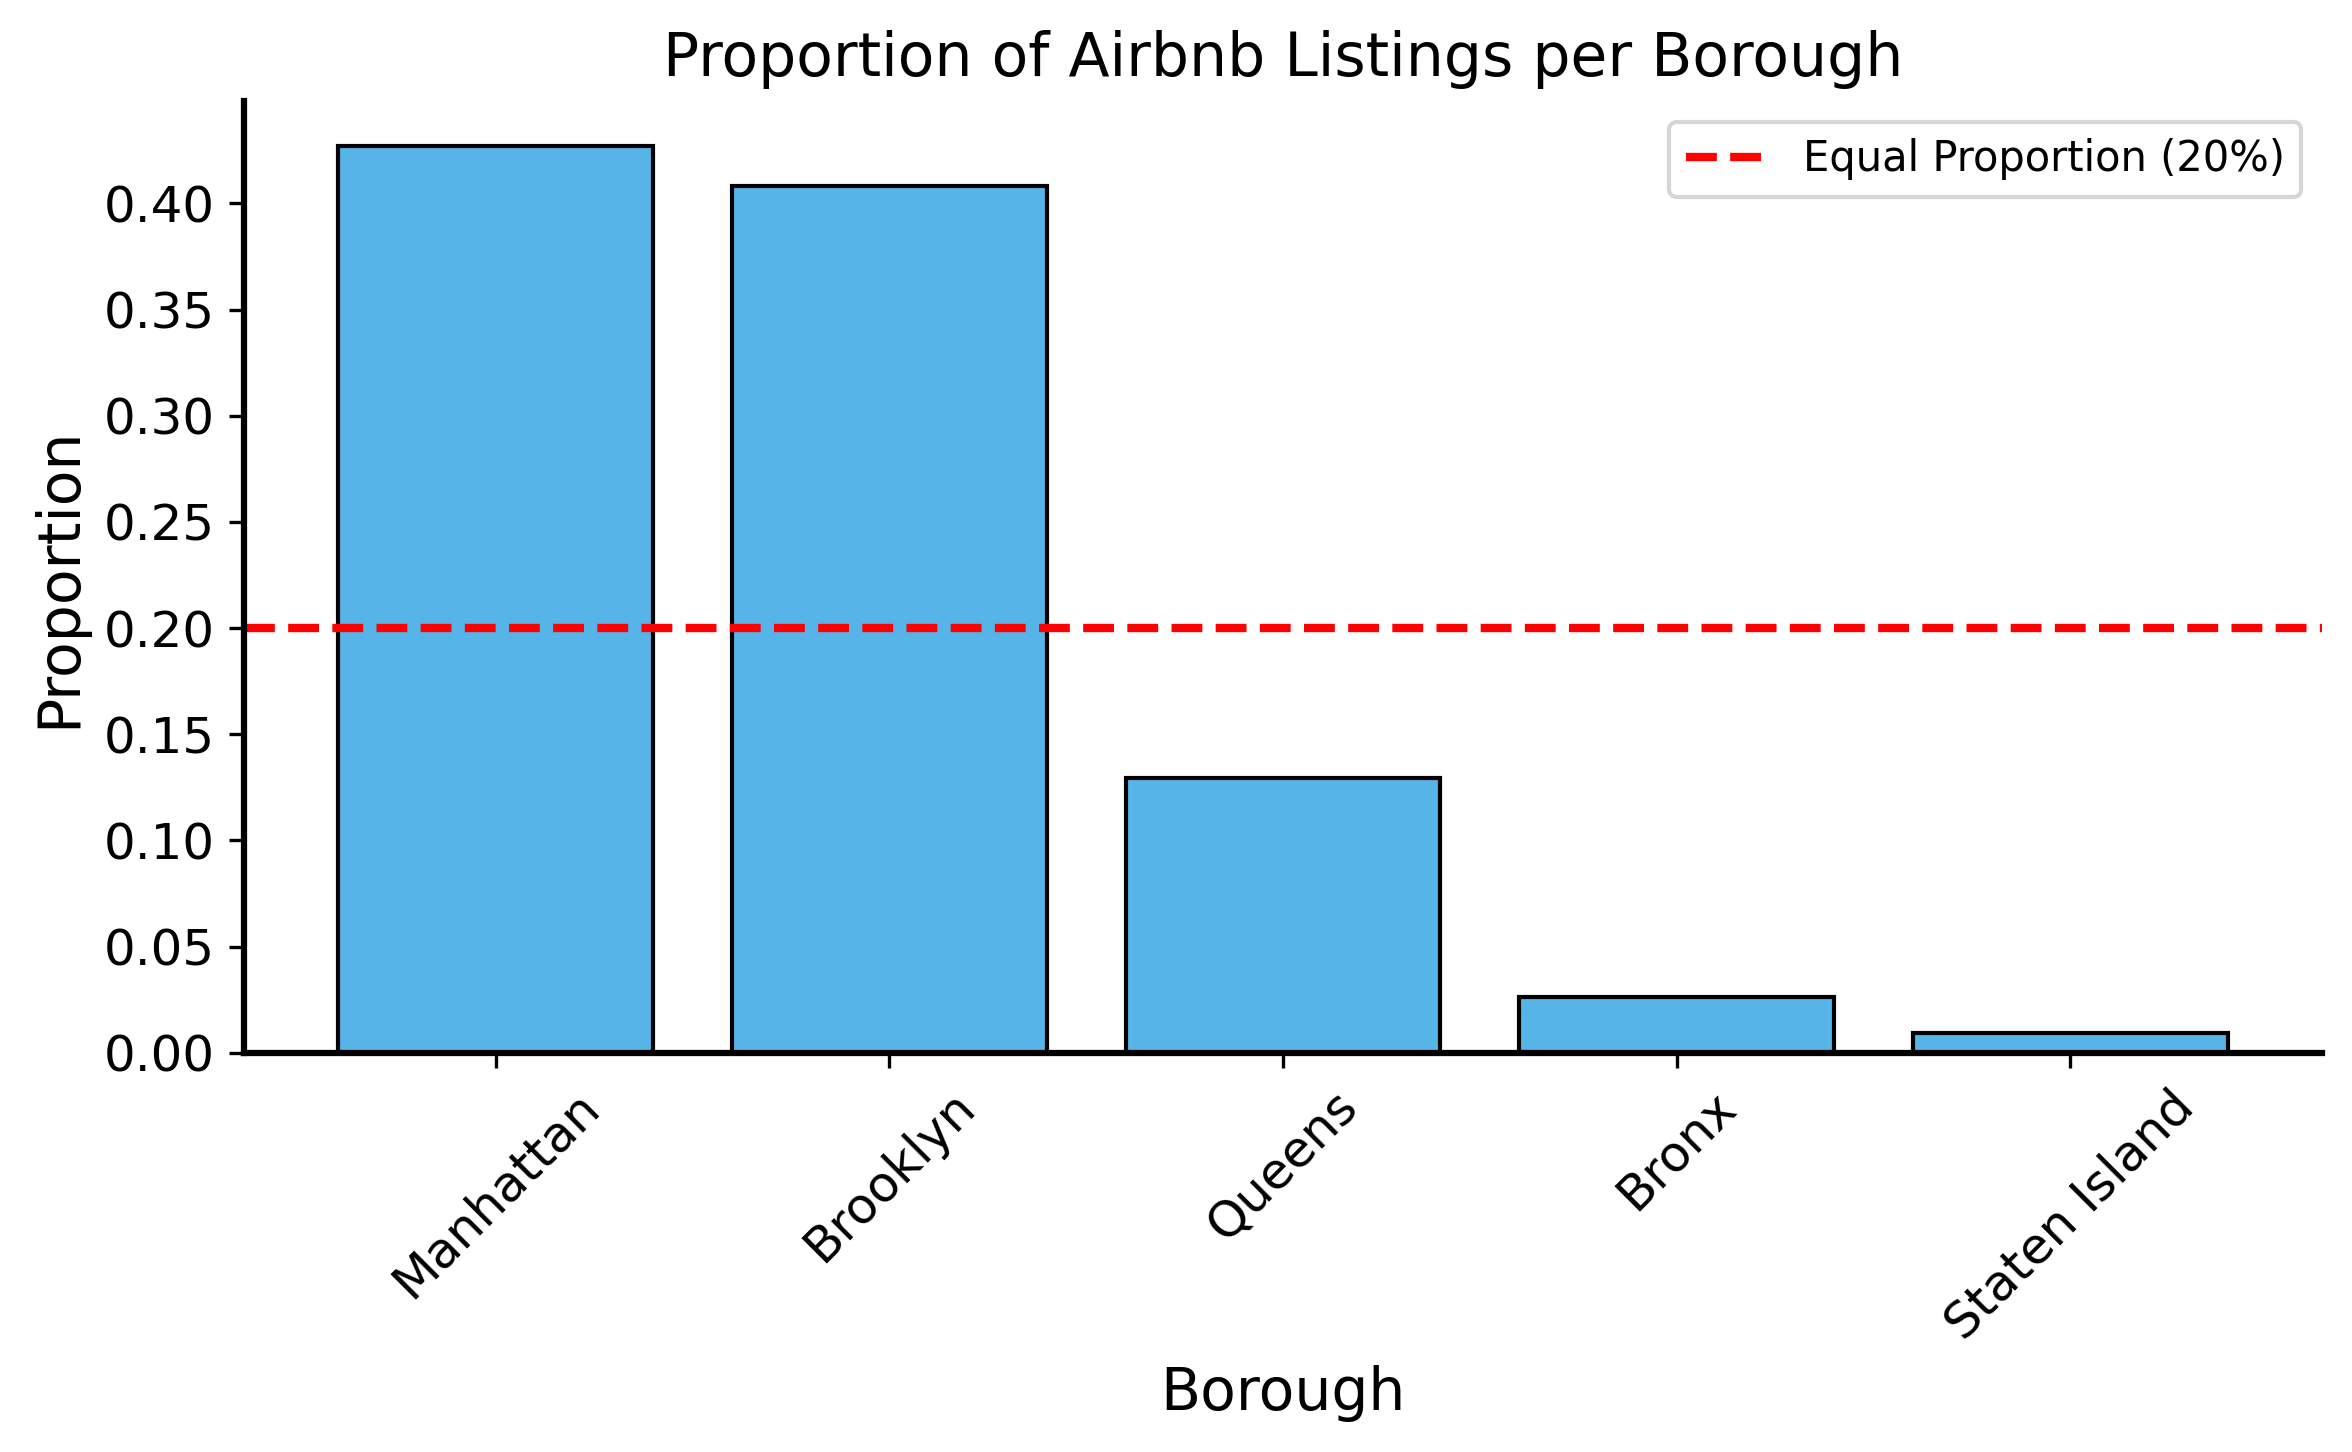

In [8]:
# number of listings per borough
borough_counts = airbnb['borough'].value_counts().rename_axis('borough').reset_index(name='count')
borough_counts['borough'] = borough_counts['borough'].str.title()  # capitalize
# normalize the counts to proportions
borough_counts['proportion'] = borough_counts['count'] / borough_counts['count'].sum()

plt.figure(figsize=(8, 5))
plt.bar(borough_counts['borough'], borough_counts['proportion'])
plt.axhline(y=1/5, color='r', linestyle='--', label='Equal Proportion (20%)')
plt.title('Proportion of Airbnb Listings per Borough')
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

. . . 

**Question**: "If we assume that all boroughs are equally likely to produce each listing, how likely is it that we would see the distribution of listings that we actually observe?"

- question about the probability of the sample, given a certain model of the DGP
- it intuitively seems unlikely that we would see so many more listings in Manhattan and Brooklyn than in the other boroughs if all boroughs were equally likely to produce listings.

## Evaluating models

What should we do now? 
- Now that we realize our sample is very unlikely under our model, then perhaps we should reconsider our model. 
- Model is just a "guess" about the DGP, while the sample is real data that we have observed. 

. . .

::: {.callout-note title="Unlikely data or unlikely model?"}
There are two main culprits when we see a sample that is unlikely under our model:

1. The sample! Think of this as "luck of the draw". This is only really a risk if your sample is small or systematically biased in some way. Usually if you collect enough data, the sample will start to look more like the population. If you flip a coin 5 times, you might get all tails (there's actually a 3% chance of this happening); if you flip a coin 100 times, there's virtually no chance that you'll get all tails (less than 10^-30^ chance). 
2. The model! This means that our assumptions about the DGP are incorrect or incomplete. This is a more serious problem, and it won't go away just by collecting more data.
:::

. . .

Statistical inference is basically just a bunch of mathematical machinery and techniques that help us to quantify this guesswork precisely and make it rigorous.

## Inference requires domain knowledge

:::{.callout-warning title="Don't try this at home!" collapse="true"}
We just said that statistical inference makes guesswork rigorous, but this is not the whole story. 

We will always do a much better job of inference if was have a good understanding of the DGP and the context of the data. 

This requires *domain knowledge* and *subject matter expertise*. 
:::

In the Airbnb example:

- Assuming that all boroughs are equally likely to produce listings is a pretty bad assumption 
  - Manhattan sees vastly more tourism than the other boroughs 
  - Brooklyn and Queens have by far the most residents according to recent census data.

## Prediction

Prediction is the process of using a model to make predictions about unseen (or future) data. 

Back to the Airbnb data: we might want to **predict** which borough a new listing belongs to based on its features (e.g., listing type, review ratings, price, etc.).

To that end we will *fit* a predictive model to the data. Basic idea of the model: 
- we assume the features of the listing (e.g., price) are related to the probability of it being in a certain borough
  - e.g., perhaps more expensive listings are more likely to be in Manhattan

. . .

:::{.callout-note title="Fitting a model"}
Models generally have *parameters*, which are adjustable values that affect the model's behavior. Think of them like "knobs" you can turn to tune the model to do what you want, like adjusting the volume or the bass/treble on a speaker. 

Coin flip has a single parameter: the probability of landing on heads. 

- If you turn the knob to 0.5, you get a fair coin; 
- if you turn it to 1.0, you get a coin that always lands on heads; 
- if you turn it to 0.0, you get a coin that always lands on tails.

Fitting a model means adjusting the parameters of the model so that it best matches the data. This is usually done by *minimizing* some kind of **error function**, which provides a measure of how well the model fits the data.
:::

## Predicting the borough of a listing

Prediction Accuracy: 45.38%


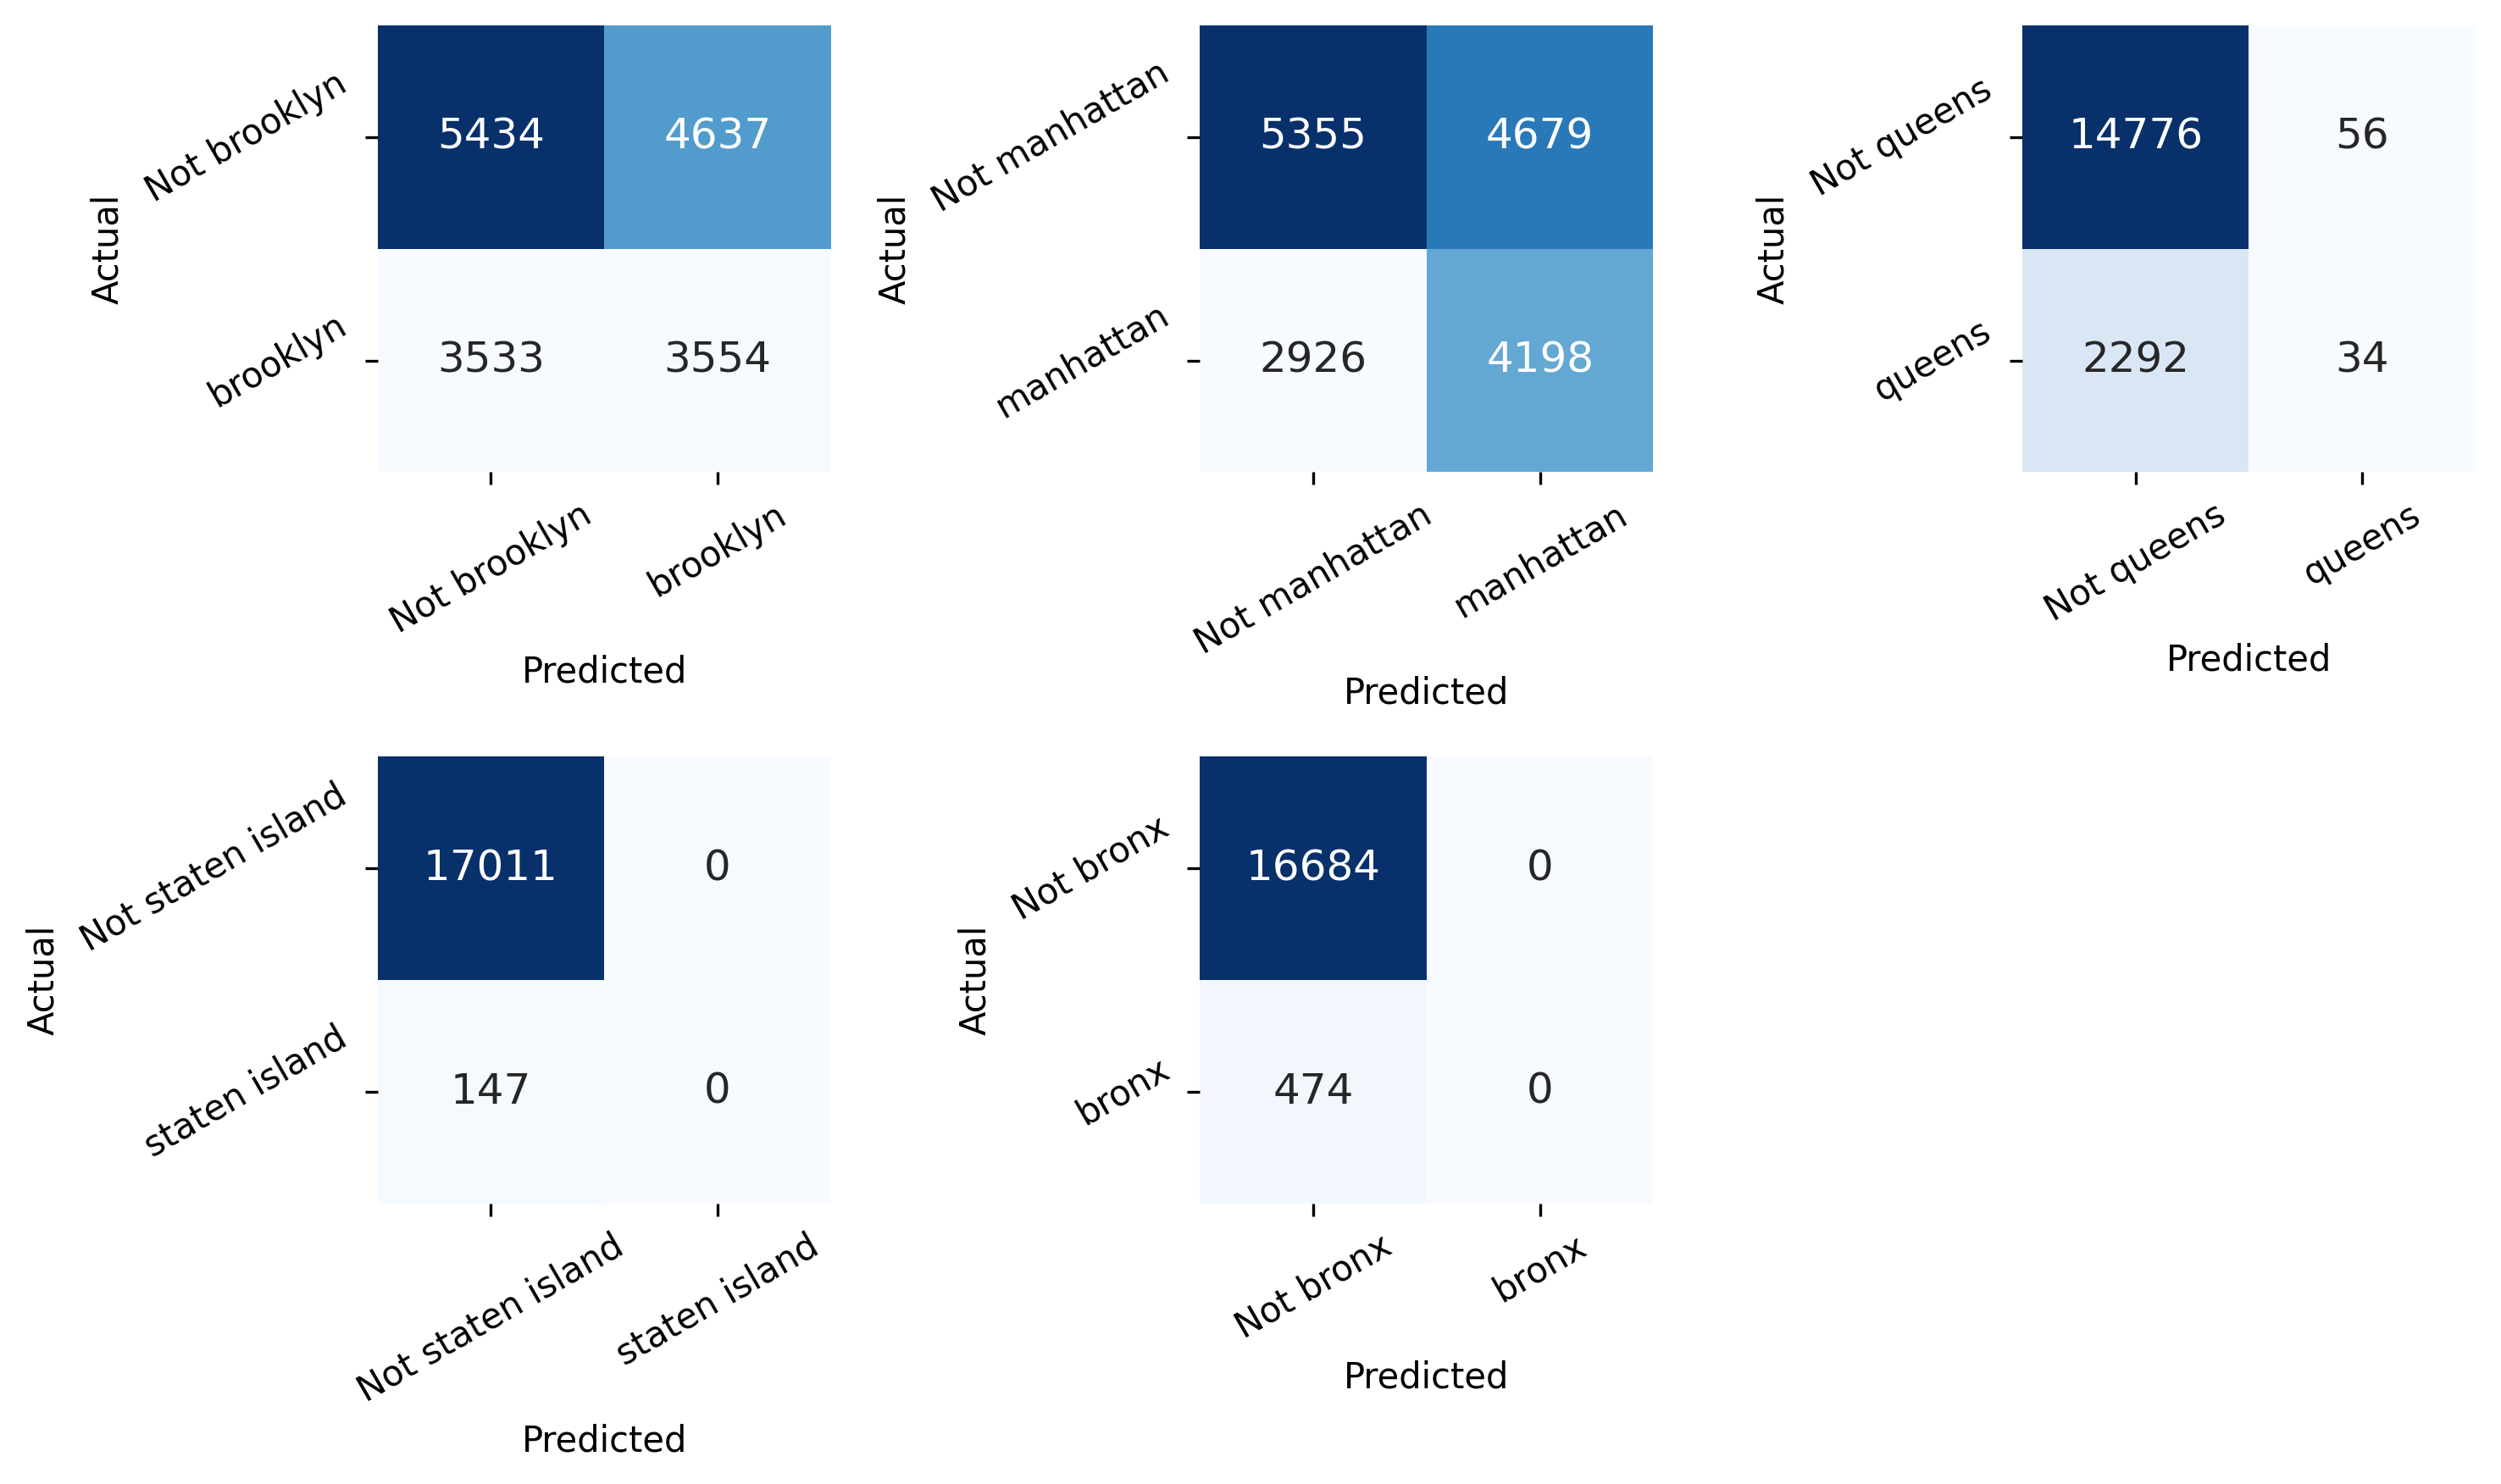

In [ ]:
# | fig-align: center
# | label: fig:borough-proportions
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# prepare the data for linear regression
feature_columns = ["price", "room_type", "minimum_nights", "number_of_reviews", "reviews_per_month", "review_rate_number"]
airbnb_clean = airbnb.dropna(subset=feature_columns + ["borough"])
X = airbnb_clean[feature_columns]
# convert categorical variables to lowercase
X.loc[:, "room_type"] = X["room_type"].str.lower()
y = airbnb_clean["borough"].values.reshape(-1)
# convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=["room_type"], drop_first=True)
X["rating_interaction"] = X["reviews_per_month"] * X["review_rate_number"]
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
# fit the logistic regression model
model = LogisticRegression(max_iter=1000, solver="newton-cholesky")
model.fit(X_train, y_train)
# make predictions on the test set
y_pred = model.predict(X_test)
# calculate the prediction accuracy
accuracy = np.mean(y_pred == y_test)
print(f"{40*'='}")
print(f'Prediction Accuracy: {accuracy:.2%}')
print(f"{40*'='}")
# calculate the confusion matrix
confusion_matrix = multilabel_confusion_matrix(y_test, y_pred, labels=airbnb['borough'].unique())
# confusion_matrix = [confusion_matrix[i].T for i in range(len(confusion_matrix))] 
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()
ax[-1].axis('off')  # turn off the last subplot since we have only 5 boroughs
# plot the confusion matrix for each borough
for i, borough in enumerate(airbnb['borough'].unique()):
    sns.heatmap(confusion_matrix[i], annot=True, fmt='d', cmap='Blues', ax=ax[i], cbar=False)
    ax[i].set_xlabel('Predicted', fontsize=10)
    ax[i].set_ylabel('Actual', fontsize=10)
    ax[i].set_xticklabels(['Not ' + borough, borough], rotation=30, fontsize=10)
    ax[i].set_yticklabels(['Not ' + borough, borough], rotation=30, fontsize=10)
plt.tight_layout()
_ = plt.show()

## Evaluating predictions
Ok, so the model is around 45% accurate at predicting the borough of a listing. 

:::{.callout-tip title='What is a "good" prediction rate?' collapse='false'}
For discussion / reflection: What is a "good" prediction rate or accuracy? Is 45% good? What about 60%? 80%? How would you tell?
:::

::: {.notes}
Later in the course, we will talk about how to evaluate models and prediction accuracy more rigorously. 

For now, just keep in mind that there is no one-size-fits-all answer to this question. It depends on factors like what you want to do with the model or how good simple alternatives might be. 

For example, you want self-driving cars to be nearly 100% accurate because the cost of a mistake is so high. Perhaps a general manager drafting prospective players for a sports team would be satisfied with 60% accuracy, since they only need to be right about some players to make a big difference in the team's performance.
:::

## Model predictions (distribution)
Now let's take a look at the distribution of the model's predictions.

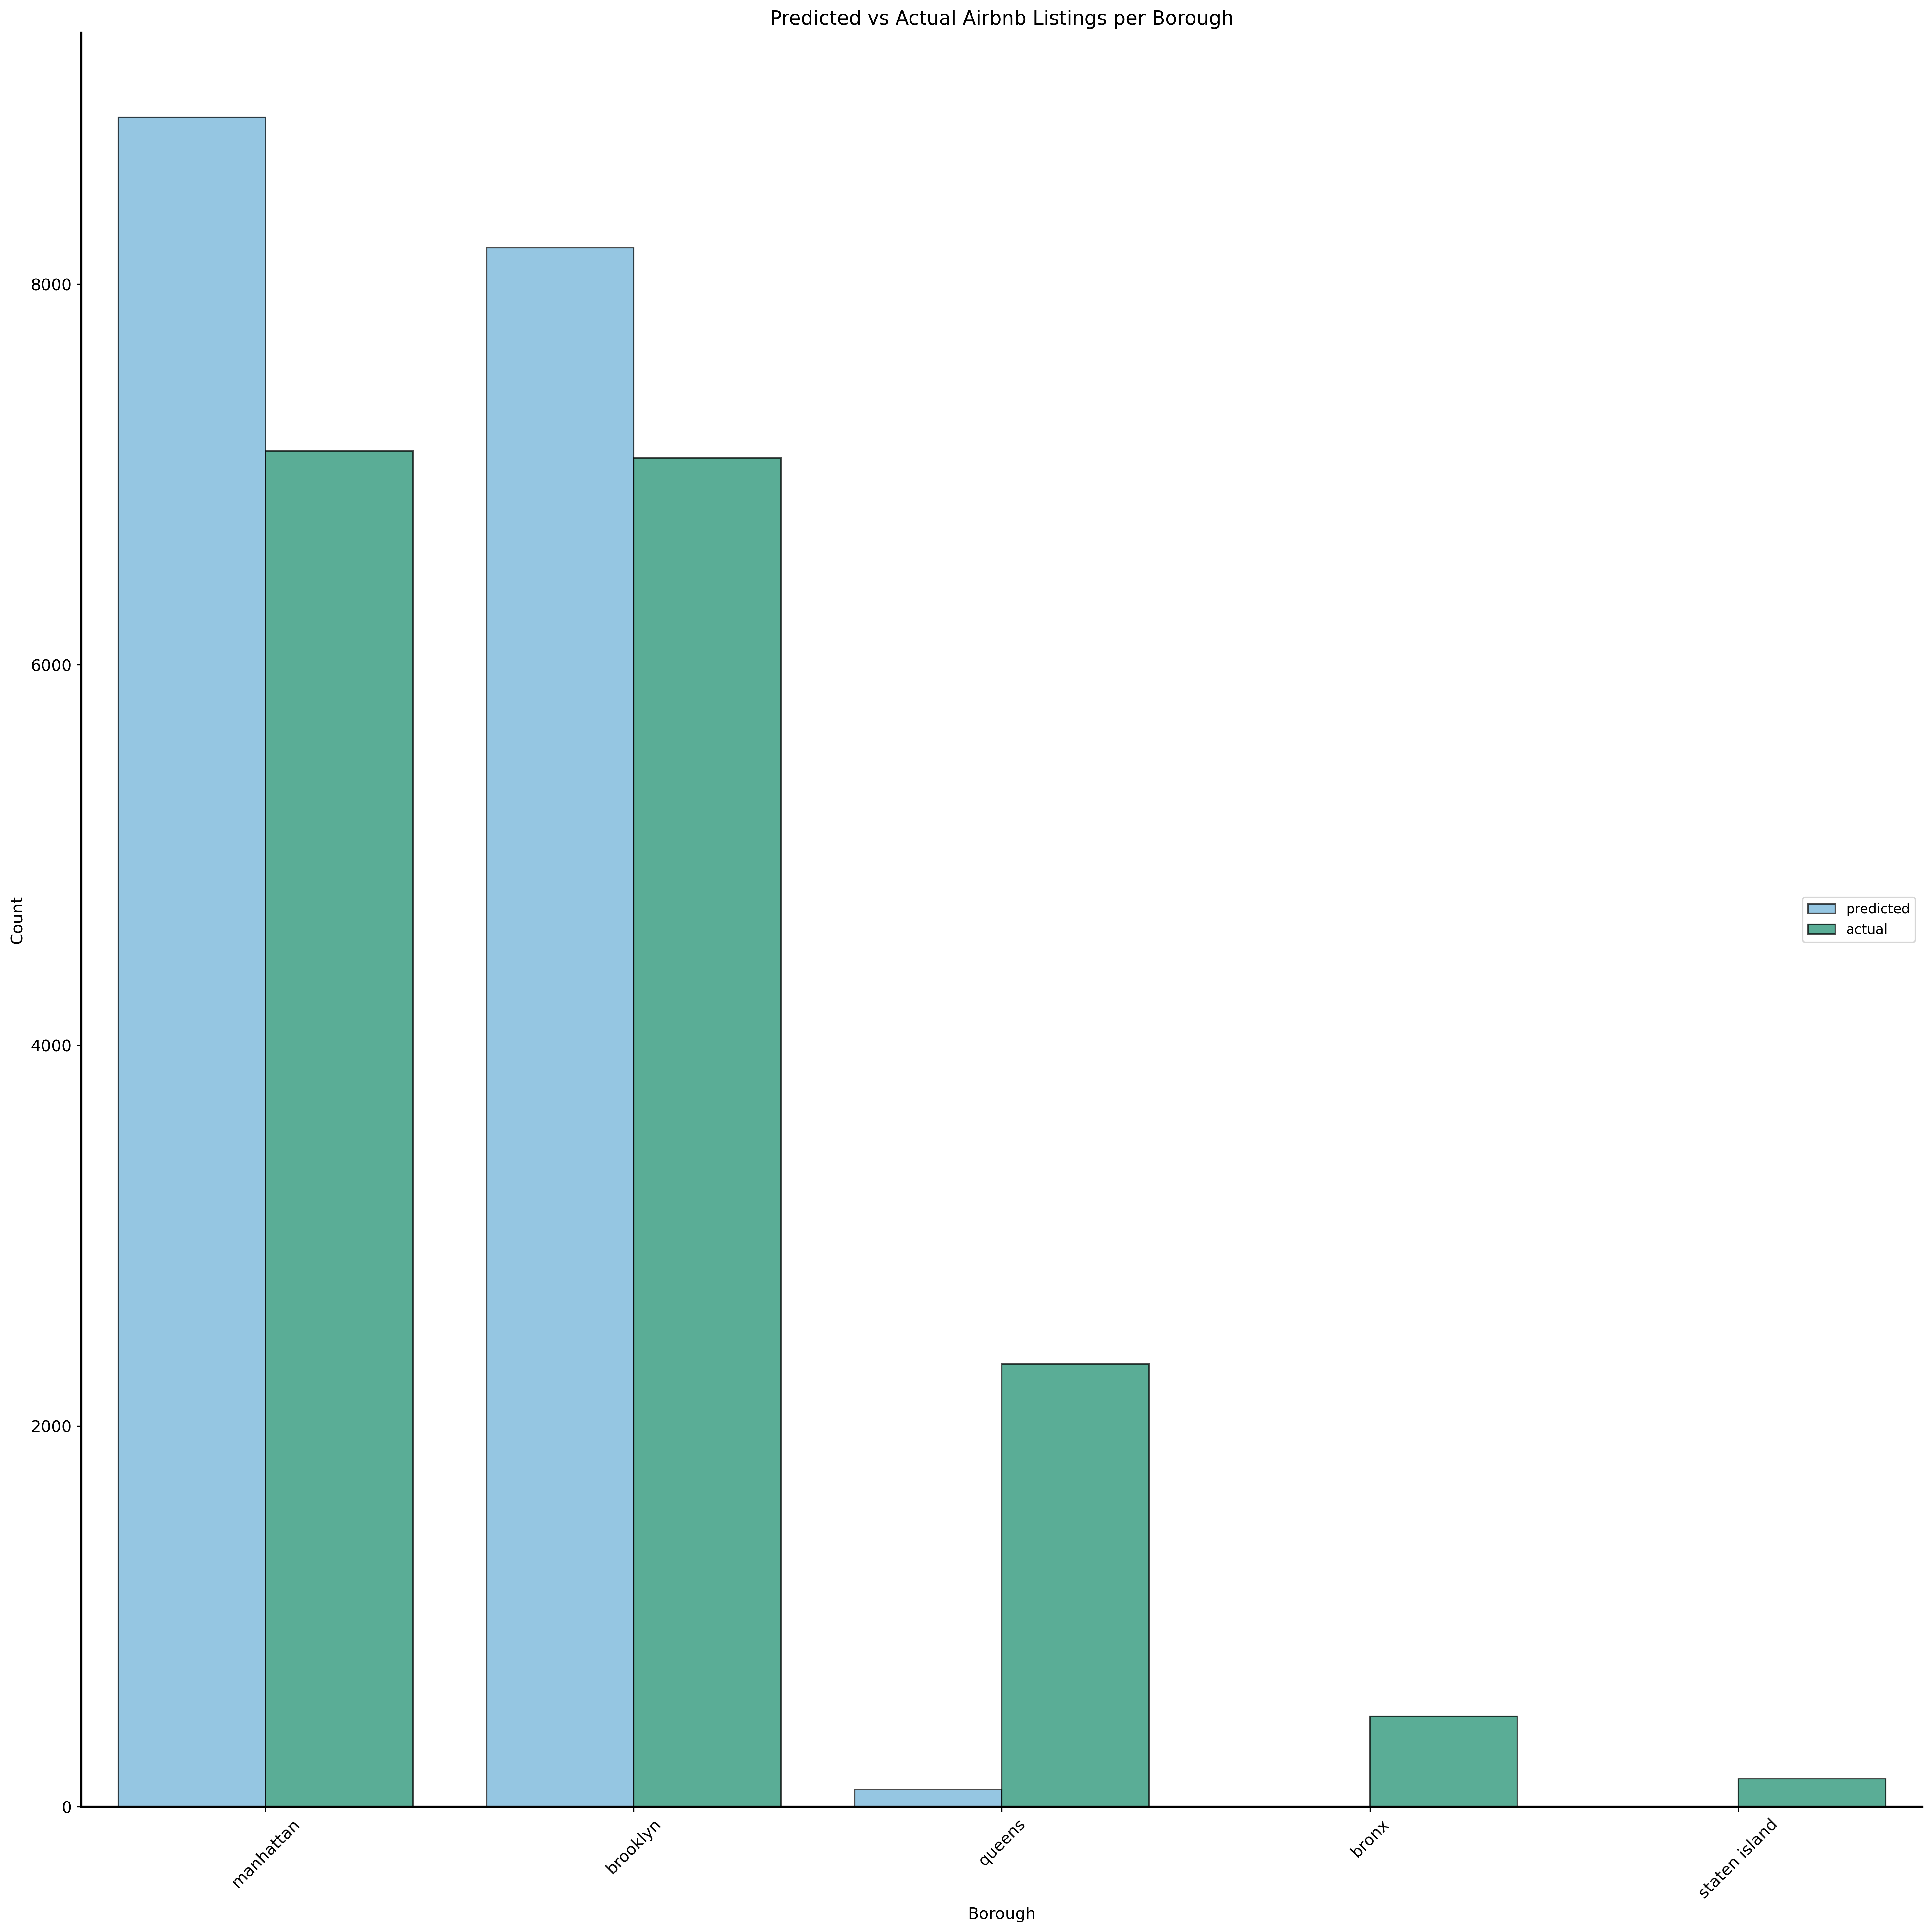

In [ ]:
#| fig-align: center
# plot the counts of predicted listings per borough side by side with the actual counts
import seaborn as sns
plot_df = pd.DataFrame({
    'predicted': pd.Series(y_pred.flatten()),
    'actual': pd.Series(y_test.flatten())
})
plot_df = plot_df.melt(var_name='type', value_name='borough')
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.countplot(x='borough', hue='type', data=plot_df, alpha=0.7, ax=ax)
sns.move_legend(ax, loc="center right", title=None)
plt.title('Predicted vs Actual Airbnb Listings per Borough')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It looks like the model is a bit crude (it predicts no listings in the Bronx or Staten Island), but it does at least capture the general trend that listings are more likely to be in Manhattan and Brooklyn than in the other boroughs. 

:::{.callout-note title="Prediction and inference can interact" collapse="true"}
Prediction and inference are closely related, and they can often be done simultaneously. 

The guiding logic is that a model that makes good predictions is probably doing a good job of capturing the underlying DGP.
:::


## Summary
In this introductory lecture we talked about the 3 objectives of data analysis: description, inference, and prediction.
Hopefully you now have a better understanding of **what** statistics is supposed to help you do with data. Of course,
we haven't actually gone into any of the details of **how** to do anything. Don't worry, we'll get there!

Next up, we'll cover some of the basic programming concepts that are important for data science. After that we will learn some foundational concepts in probability that will help us think about data and models more rigorously. From there, the sky is the limit! We'll cover a wide range of topics, including statistical inference, uncertainty quantification, machine learning, and more.

Since we haven't learning any programming or statistics yet, we won't have any real exercises for this lecture. 
There's just a quick [Assignment 0](../assignments/assignment-00.ipynb) to make sure you are set up to run Python code for future assignments.

<!-- {{< embed ../assignments/assignment-00.ipynb#hello-world >}} -->